# Model Evaluation Notebook

#### Overview
This notebook implements a comprehensive evaluation pipeline for the trained CIFAR-10 classifier. It includes:
- Model loading and configuration
- Test set evaluation
- Performance metrics calculation
- Error analysis
- Visualization of results

#### Key Features
- Detailed performance metrics (accuracy, precision, recall, F1-score)
- Confusion matrix visualization
- Per-class performance analysis
- Error case analysis
- Prediction visualization

#### Model Loading and Configuration

In [1]:
# Standard library imports
import sys
import os
from pathlib import Path
import json
import numpy as np

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Project imports
import config
from utils.paths import MODELS_DIR, DATA_DIR
from core.cifar10_classifier import CIFAR10Classifier
from utils.visualization import (
    plot_confusion_matrix,
    print_per_class_accuracy,
    show_random_samples
)

# Model configuration
model_name = "cnn_mixup_cutout_SGD"  # or your model name
model_dir = os.path.join(MODELS_DIR, model_name)
metrics_path = os.path.join(model_dir, f"{model_name}_metrics.json")
config_path = os.path.join(model_dir, f"{model_name}_config.json")
model_path = os.path.join(MODELS_DIR, model_name,  f"{model_name}_best_model.pth")

# Load model configuration
with open(config_path, 'r') as f:
    model_config = json.load(f)

##### Model & Config loading

In [2]:
assert os.path.exists(config_path), f"Config not found at {config_path}"
assert os.path.exists(model_path), f"Model not found at {model_path}"

model = CIFAR10Classifier.load_model(
    model_name=model_name,
    config_path=config_path,
    model_path=model_path
)

print(model.summary())
print(f"✅ Model restored: {model_name}")

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR10_CNN                              [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           128
│    └─ReLU: 2-7                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-8                    [1, 64, 8, 8]             --
│    └─Conv2d: 2-9                       [1, 128, 8, 8]            73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 8, 8]            256
│    └─ReLU: 2-11                        [1, 128, 8, 8]            --
│   

##### Training History Overview
This section visualizes how the model's loss and accuracy evolved over time.

📊 Training plot saved to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\cnn_mixup_cutout_SGD\cnn_mixup_cutout_SGD_metrics.png


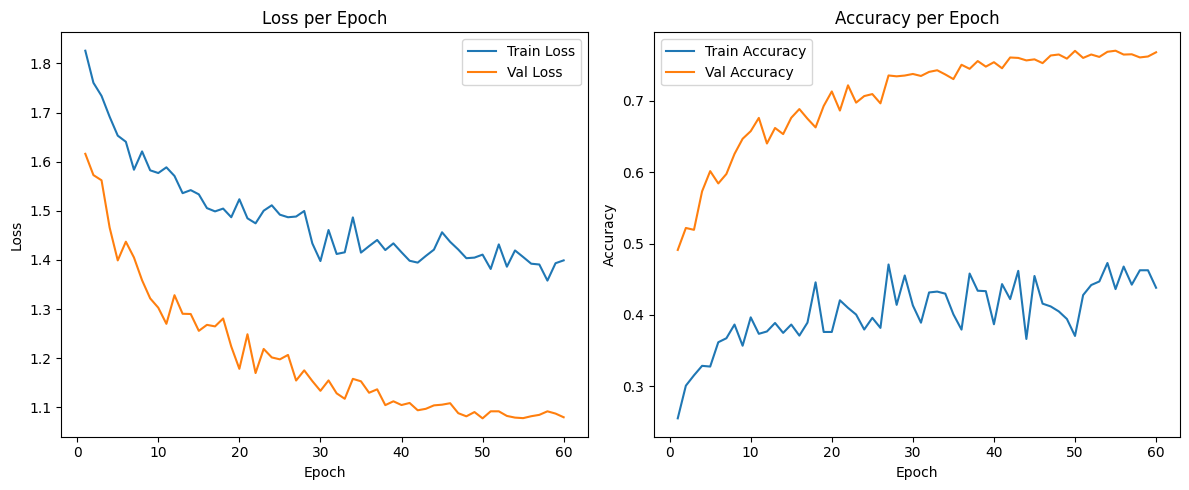

In [3]:
metrics_path = os.path.join(MODELS_DIR, model_name, f"{model_name}_metrics.json")
model.plot_training_history(metrics_path)

##### Test Set Loading
This section prepares the test dataset using the same normalization as during training (no augmentations).


In [4]:
import torch

# data loading
from utils.data_utils import (
    get_transforms,
    load_cifar10_datasets, create_loaders
)

mean, std = torch.tensor(model.mean), torch.tensor(model.std)
# Apply transformations
full_transform = get_transforms(mean, std, augmentation=False, grayscale=model.grayscale)

# Load with transformations
_, test_dataset = load_cifar10_datasets(data_dir=DATA_DIR, transform=full_transform, subset="test")
# extract class names
class_names = test_dataset.classes

# Loaders
_, _, test_loader = create_loaders(_, _, test_dataset, batch_size=config.BATCH_SIZE)

🧪 Creating transform pipeline...
🧪 Transform pipeline:
  └─ Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
  └─ ToTensor()
  └─ Normalize(mean=[0.4913996756076813, 0.48215851187705994, 0.4465310275554657], std=[0.24703219532966614, 0.24348489940166473, 0.2615877091884613])
📥 Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading test dataset
Files already downloaded and verified
✅ Loaded test samples: 10000
📦 Creating data loaders with batch size 256...
✅ Data loaders ready.


### Metrics

#### Test Set Evaluation
Calculates accuracy and loss on the held-out test set.

In [5]:
# Evaluate model
metrics = model.evaluate(test_loader)
print(f"Test accuracy: {metrics['accuracy']:.4f}")
print(f"Test loss: {metrics['loss']:.4f}")

Validation loss: 0.9635, accuracy: 0.8168
Test accuracy: 0.8168
Test loss: 0.9635


#### Classification Report
Shows per-class precision, recall, and F1-score on the test set.

In [6]:
# Print classification report
from sklearn.metrics import classification_report

print("\n📈 Detailed Classification Report:")
print(classification_report(
    metrics["y_true"],
    metrics["y_pred"],
    target_names=test_dataset.classes
))


📈 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.88      0.82      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.68      0.79      0.73      1000
         cat       0.69      0.65      0.67      1000
        deer       0.83      0.76      0.79      1000
         dog       0.75      0.72      0.73      1000
        frog       0.88      0.84      0.86      1000
       horse       0.86      0.83      0.85      1000
        ship       0.91      0.89      0.90      1000
       truck       0.92      0.85      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



### Visualizations

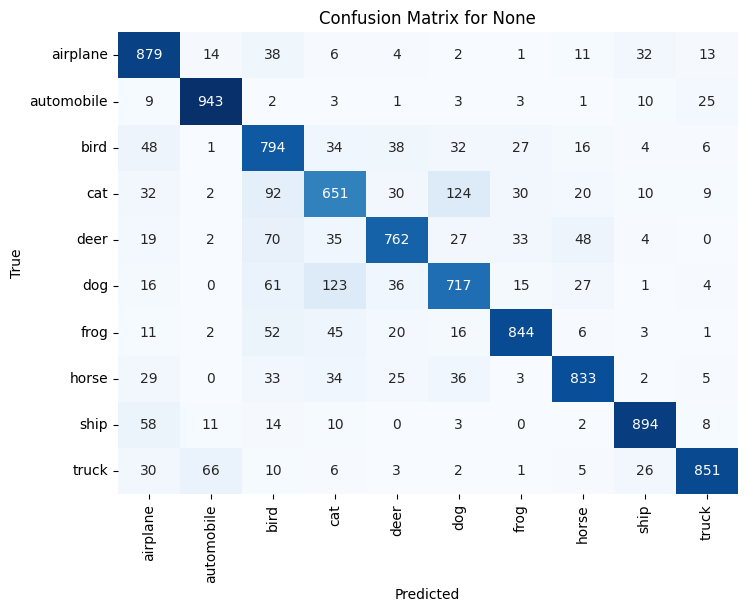

In [7]:
# Plot confusion matrix
model.plot_confusion_matrix(metrics["y_pred"], metrics["y_true"], class_names=class_names)

In [8]:
# Analyze errors
# Convert lists to numpy arrays
y_pred = np.array(metrics['y_pred'])
y_true = np.array(metrics['y_true'])
probs = np.array(metrics['probs'])

# Calculate overall metrics
error_indices = np.where(y_pred != y_true)[0]
error_probs = probs[error_indices]
total_predictions = len(y_pred)
correct_predictions = np.sum(y_pred == y_true)
accuracy = correct_predictions/total_predictions

# Print overall results
print("\n📊 Model Evaluation Results")
print("=" * 60)
print(f"Total samples: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Total errors: {len(error_indices)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Error rate: {len(error_indices)/len(y_true):.4f}")

# Calculate per-class statistics
error_predictions = y_pred[error_indices]
error_true = y_true[error_indices]
error_counts = np.bincount(error_true, minlength=len(class_names))
total_counts = np.bincount(y_true, minlength=len(class_names))
error_rates = error_counts / total_counts

# Print per-class results
print("\n📈 Per-Class Performance")
print("=" * 60)
print(f"{'Class':<15} {'Total':<10} {'Errors':<10} {'Error Rate':<12} {'Accuracy':<12}")
print("-" * 60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {total_counts[i]:<10} {error_counts[i]:<10} "
          f"{error_rates[i]:<12.4f} {(1 - error_rates[i]):<12.4f}")


📊 Model Evaluation Results
Total samples: 10000
Correct predictions: 8168
Total errors: 1832
Accuracy: 0.8168
Error rate: 0.1832

📈 Per-Class Performance
Class           Total      Errors     Error Rate   Accuracy    
------------------------------------------------------------
airplane        1000       121        0.1210       0.8790      
automobile      1000       57         0.0570       0.9430      
bird            1000       206        0.2060       0.7940      
cat             1000       349        0.3490       0.6510      
deer            1000       238        0.2380       0.7620      
dog             1000       283        0.2830       0.7170      
frog            1000       156        0.1560       0.8440      
horse           1000       167        0.1670       0.8330      
ship            1000       106        0.1060       0.8940      
truck           1000       149        0.1490       0.8510      


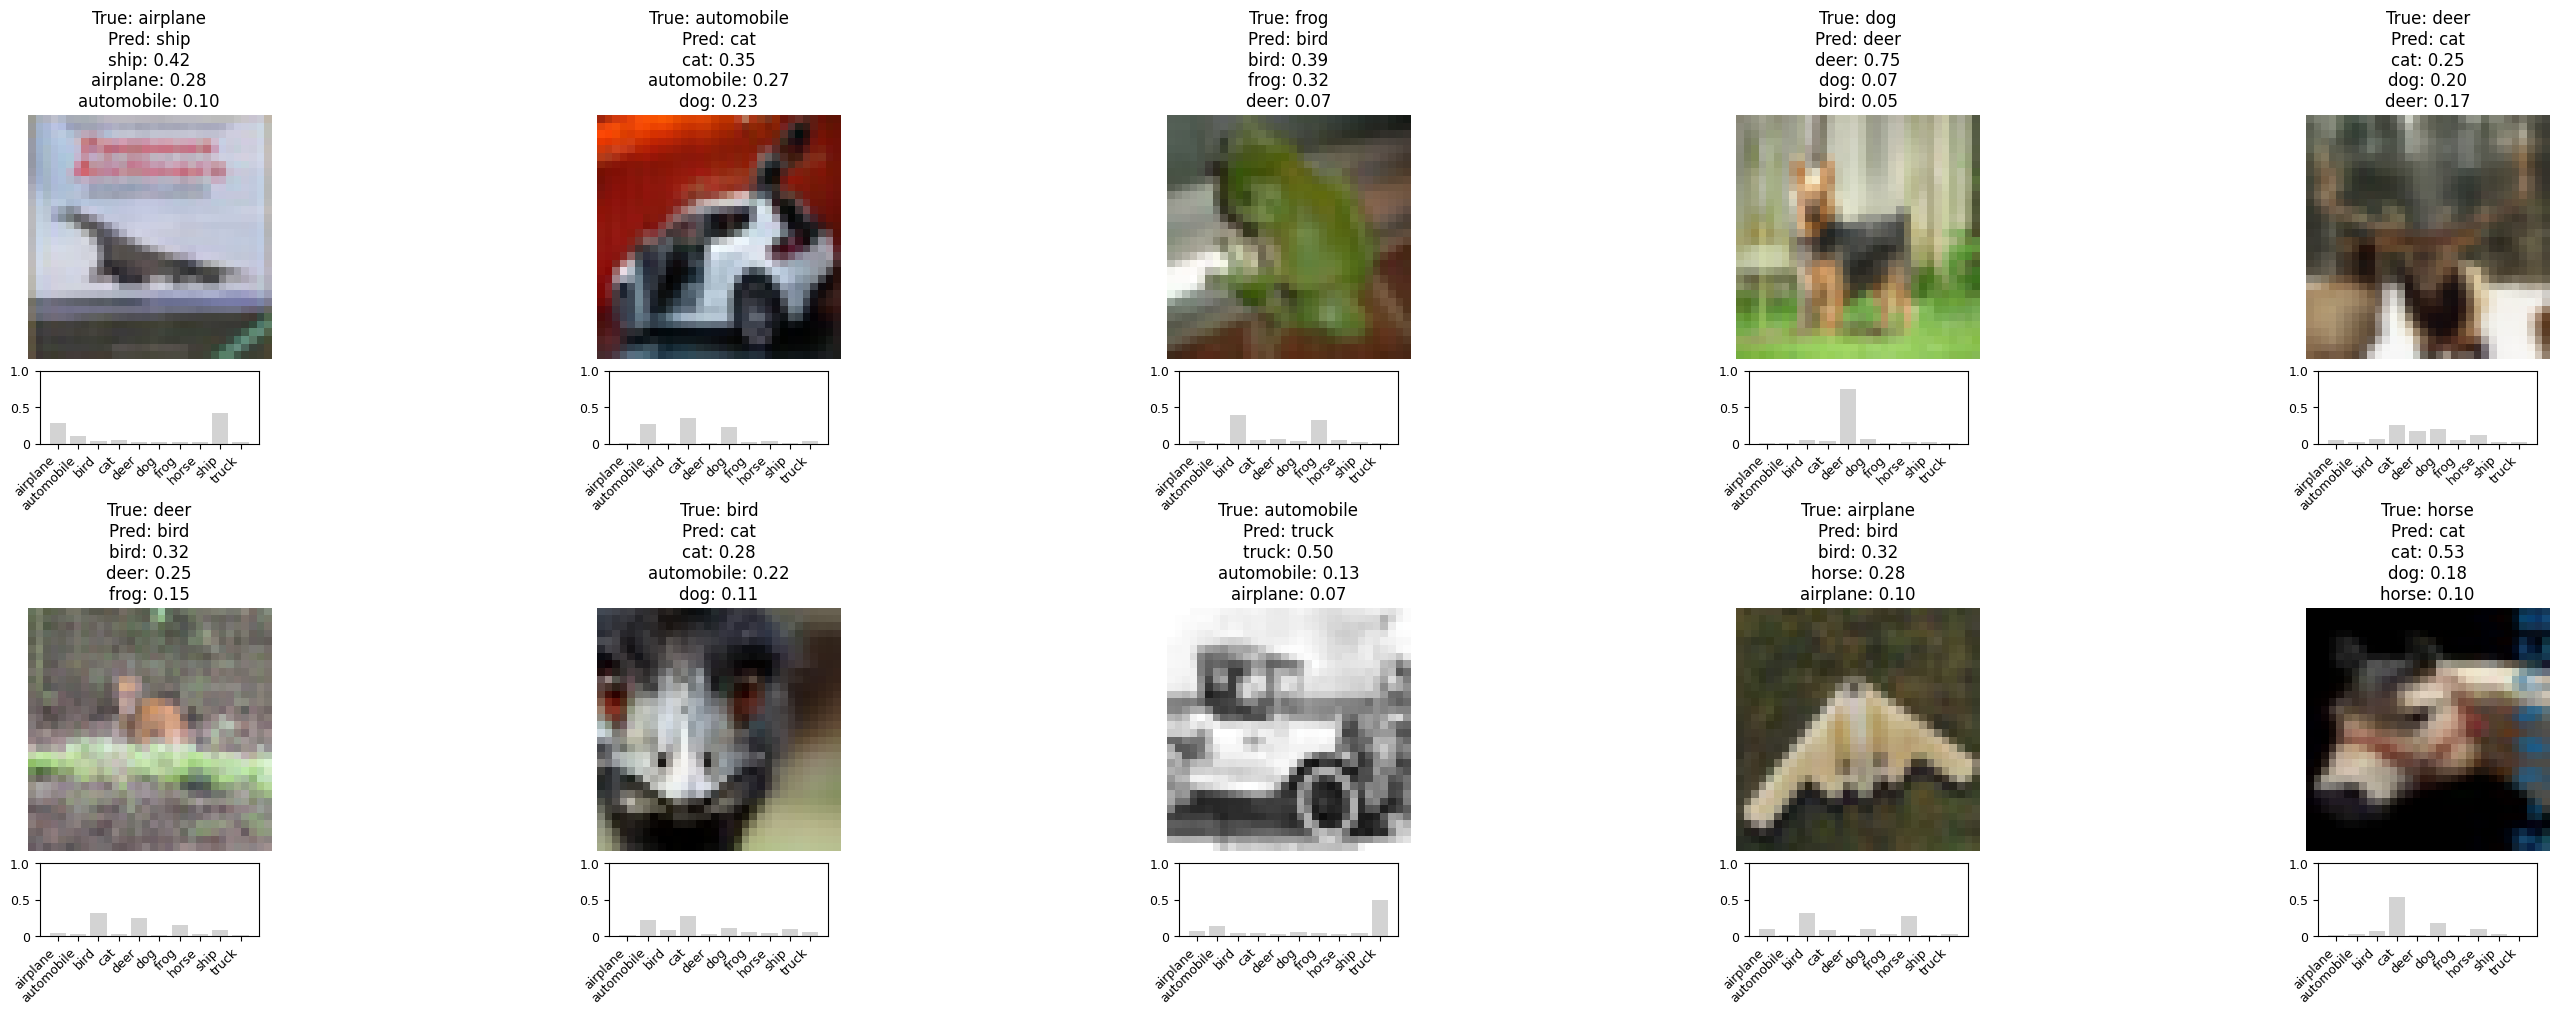

In [9]:
# Show some error cases
model.show_misclassified(data_loader=test_loader, class_names=class_names, max_images=10)

### Save results

In [10]:
from sklearn.metrics import confusion_matrix

# Save evaluation results
results = {
    'model_name': model_name,
    'test_accuracy': float(metrics['accuracy']),
    'error_rate': float(len(error_indices)/len(metrics["y_true"])),
    'confusion_matrix': confusion_matrix(metrics["y_true"], metrics["y_pred"]).tolist(),
    'classification_report': classification_report(
        metrics["y_true"],
        metrics["y_pred"],
        target_names=test_dataset.classes,
        output_dict=True
    ),
    "top_k_errors": [[int(t), int(p)] for t, p in zip(metrics["y_true"], metrics["y_pred"]) if t != p][:10],
    "confidence_on_errors": [float(np.max(prob)) for prob in error_probs],
    "true_labels": [int(t) for t in metrics["y_true"]],
    "predicted_labels": [int(p) for p in metrics["y_pred"]]
}

results_path = os.path.join(model_dir, f"{model_name}_evaluation.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f"\n✅ Evaluation results saved to {results_path}")


✅ Evaluation results saved to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\models\cnn_mixup_cutout_SGD\cnn_mixup_cutout_SGD_evaluation.json


#### Predictions samples

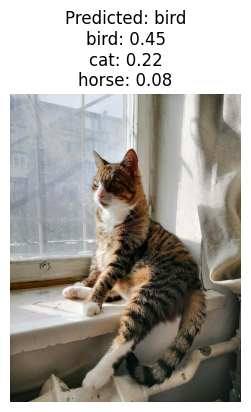

'bird'

In [11]:
# make prediction for a single image
image_path = os.path.join(DATA_DIR,"samples","Image20250601203635.jpg")
model.predict_image(path=image_path, transform=full_transform, class_names=class_names)


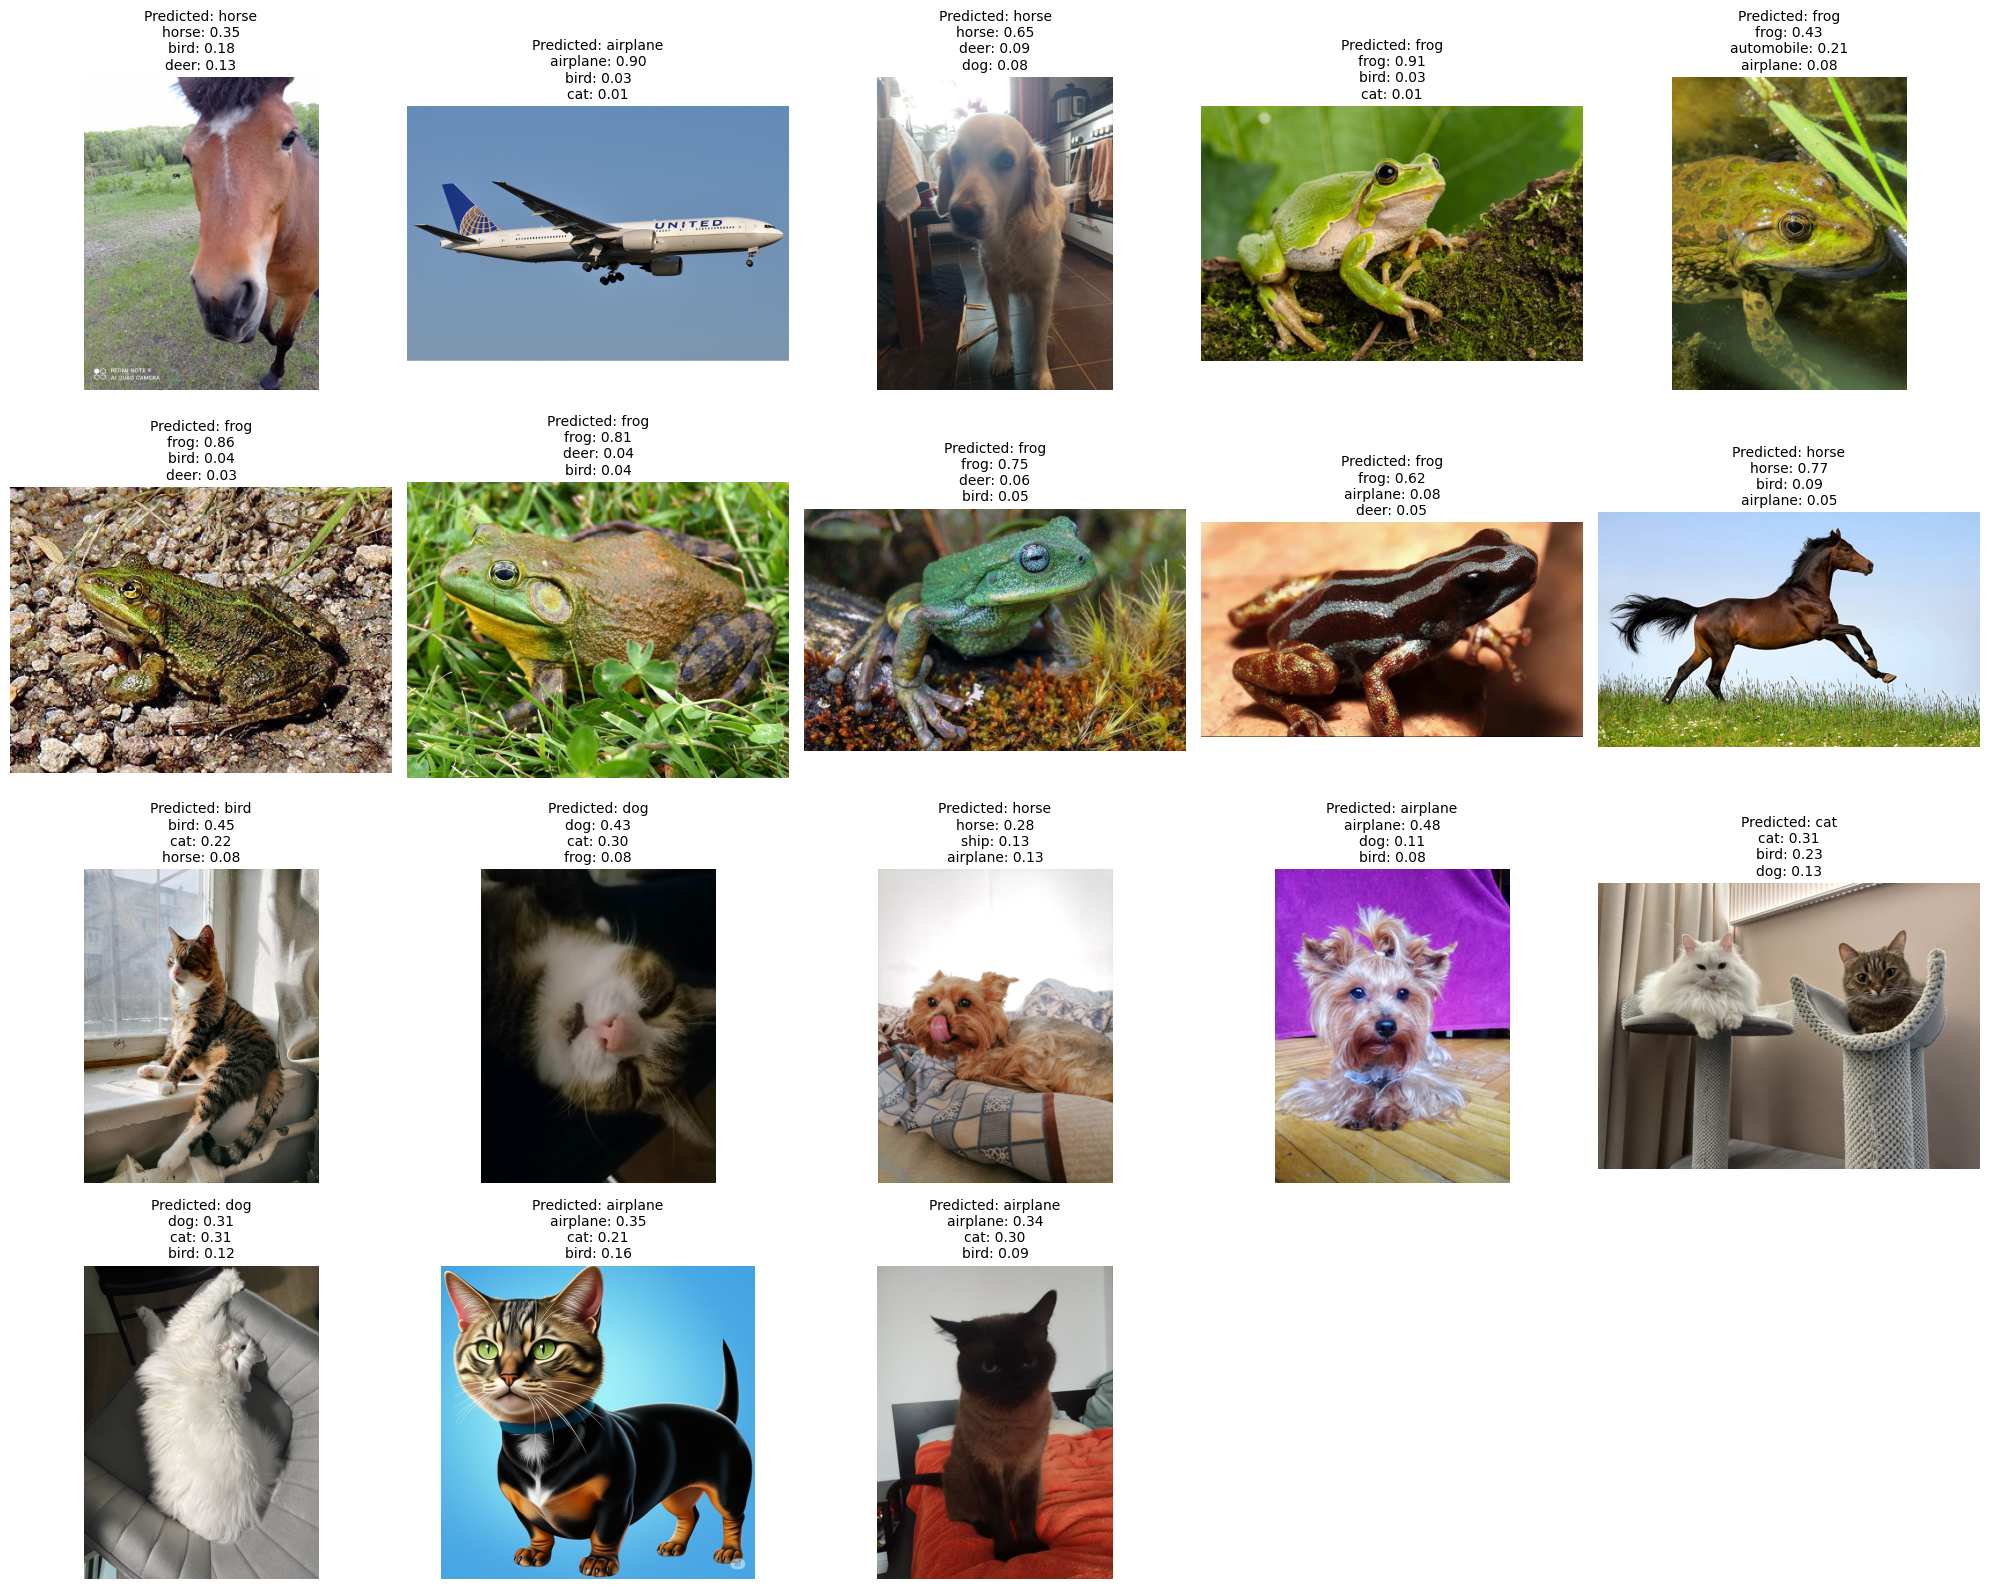

[('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\5323608996025860502.jpg',
  'horse'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\airplane.jpg',
  'airplane'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\Ayri.jpg',
  'horse'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\frog.jpg',
  'frog'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\frog2.jpg',
  'frog'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\frog3.jpg',
  'frog'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\frog4.jpg',
  'frog'),
 ('c:\\Users\\pbori\\Documents\\ML AI Courses\\Homework\\CIFAR10_Torch_Classifier\\data\\samples\\frog5.jpg',
  'frog'),
 ('c:\\User

In [12]:
# make prediction for a folder of images
images_path = os.path.join(DATA_DIR,"samples")
model.predict_images(directory=images_path, transform=full_transform, class_names=class_names)